In [1]:
import random

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.sparse as sparse
from torch_geometric.nn import GCNConv

import torch
import geopandas as gpd
from shapely.geometry import LineString

import pickle

from two_channel_gnn import TwoChannelGNN
from two_channel_edge_gnn import TwoChannelEdgeGNN

In [2]:
import wandb
print(wandb.__version__)

0.17.0


In [3]:
wandb.login

<function wandb.sdk.wandb_login.login(anonymous: Optional[Literal['must', 'allow', 'never']] = None, key: Optional[str] = None, relogin: Optional[bool] = None, host: Optional[str] = None, force: Optional[bool] = None, timeout: Optional[int] = None, verify: bool = False) -> bool>

# Abstract

1. Set up a toy example: 
    a. Define the graph 
    b. Visualize the graph with the base case (without policy interventions)
2. Define the model (move this later to an own class)
3. Create train und test data (toy example)
4. Test the model (toy example)

In [4]:
def check_and_replace_inf(policy_data):
    has_inf = False
    inf_sources = {"capacity": 0, "freespeed": 0, "mode": 0}
    
    for i, row in enumerate(policy_data):
        capacity, freespeed, modes = row[0], row[1], row[2]
        
        # Check freespeed for inf values
        if freespeed == float('inf') or freespeed == float('-inf'):
            # print(f"Inf value found in freespeed at row {i}: {freespeed}")
            has_inf = True
            inf_sources["freespeed"] += 1
            row[1] = 1e6 if freespeed == float('inf') else -1e6
    return policy_data, has_inf, inf_sources


# Define a dictionary to map each mode to an integer
mode_mapping = {
    'bus': 0,
    'car': 1,
    'car_passenger': 2,
    'pt': 3,
    'bus,car,car_passenger': 4,
    'bus,car,car_passenger,pt': 5,
    'car,car_passenger': 6,
    'pt,rail,train': 7,
    'bus,pt': 8,
    'rail': 9,
    'pt,subway': 10,
    'artificial,bus': 11,
    'artificial,rail': 12,
    'artificial,stopFacilityLink,subway': 13,
    'artificial,subway': 14,
    'artificial,stopFacilityLink,tram': 15,
    'artificial,tram': 16,
    'artificial,bus,stopFacilityLink': 17,
    'artificial,funicular,stopFacilityLink': 18,
    'artificial,funicular': 19
}

# Function to encode modes into integer format
def encode_modes(modes):
    return mode_mapping.get(modes, -1)  # Use -1 for any unknown modes

def create_edge_index_and_tensors(gdf):
    # Ensure the GeoDataFrame is projected in a geographic CRS
    gdf = gdf.to_crs(epsg=4326)
    
    # Extract unique nodes (start and end points of LineStrings)
    nodes = {}
    edges = []
    car_volume_counts = []
    capacities = []
    freespeeds = []
    modes_list = []
    node_counter = 0

    for idx, row in gdf.iterrows():
        line = row['geometry']
        car_volume = row['vol_car']  # Extract car volume
        capacity = row['capacity']  # Extract capacity
        freespeed = row['freespeed']  # Extract freespeed speed
        modes = encode_modes(row['modes']) # Extract modes
        if isinstance(line, LineString):
            start_point = line.coords[0]
            end_point = line.coords[-1]
            
            if start_point not in nodes:
                nodes[start_point] = node_counter
                node_counter += 1
            if end_point not in nodes:
                nodes[end_point] = node_counter
                node_counter += 1
            
            start_index = nodes[start_point]
            end_index = nodes[end_point]
            
            edges.append((start_index, end_index))
            car_volume_counts.append(car_volume)  # Store activity count for this edge
            capacities.append(capacity)  # Store capacity for this edge
            freespeeds.append(freespeed)  # Store freespeed speed for this edge
            modes_list.append(modes)  # Store modes for this edge
    
    # Create edge_index tensor
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    # Create car volume tensor
    car_volume_tensor = torch.tensor(car_volume_counts, dtype=torch.float)
    
    # Create policy_tensor
    policy_data = [[cap, fs, mode] for cap, fs, mode in zip(capacities, freespeeds, modes_list)]
    policy_data, has_inf, inf_sources = check_and_replace_inf(policy_data)
    # if has_inf:
    #     print("Inf values were found and replaced in policy_data.")
    #     print("Inf value sources:", inf_sources)
    
    policy_tensor = torch.tensor(policy_data, dtype=torch.float)
    return edge_index, car_volume_tensor, policy_tensor, nodes

def visualize_data(policy_features, flow_features, title):
    edges = edge_index.T.tolist()

    # Create a networkx graph from the edge list
    G = nx.Graph(edges)

    # Create a colormap for flow features
    flow_cmap = plt.cm.Reds     # colormap for flow features

    # Extract flow features from tensor
    flow_values = flow_features.tolist()      # flow graph has only one feature atm

    # Normalize features for colormap mapping
    flow_min = 0
    flow_max = 100
    norm = Normalize(vmin=flow_min, vmax=flow_max)

    # Draw the graph with separate lines for flow features on each edge and annotations for policy features
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

    # Set to store processed edges
    processed_edges = set()

    # Draw edges for flow features and annotate with policy features
    for i, (u, v) in enumerate(edges):
        # Check if the edge has already been processed
        if (u, v) not in processed_edges and (v, u) not in processed_edges:
            flow_color = flow_cmap((flow_values[i] - flow_min) / (flow_max - flow_min))
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=flow_color, width=2, alpha=0.7)

            # Annotate with policy feature values
            policy_values_str = ", ".join([f"{int(val)}" for val in policy_features[i]])
            plt.text((pos[u][0] + pos[v][0]) / 2, (pos[u][1] + pos[v][1]) / 2, f"({policy_values_str})", fontsize=8, color="black", ha="center", va="center")

            # Add the edge to the set of processed edges
            processed_edges.add((u, v))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue", alpha=0.8)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

    # Add colorbar for flow features
    flow_sm = plt.cm.ScalarMappable(norm=norm, cmap=flow_cmap)
    flow_sm.set_array([])
    plt.colorbar(flow_sm, label="Flow")
    plt.title(title)
    # if "Train" in title:
    #     plt.savefig(f"visualisation/train_data/{title}.png", dpi = 500)
    # else:
    #     plt.savefig(f"visualisation/test_data/{title}.png", dpi = 500)

In [5]:
# Load the dictionary
with open('../results/result_dic.pkl', 'rb') as f:
    results_dict = pickle.load(f)

In [6]:
datasets = []
for key, df in results_dict.items():
    print(f"Policy: {key}")
    
    if isinstance(df, pd.DataFrame):
        gdf = gpd.GeoDataFrame(df, geometry='geometry')
        gdf.crs = "EPSG:2154"  # Assuming the original CRS is EPSG:2154
        gdf.to_crs("EPSG:4326", inplace=True)
        edge_index, car_volume_tensor, policy_tensor, nodes = create_edge_index_and_tensors(gdf)
        datasets.append((policy_tensor, car_volume_tensor))
    else:
        print(f"The value for key '{key}' is not a GeoDataFrame.")

Policy: policy introduced in Arrondissement(s) 5, 6
Policy: policy introduced in Arrondissement(s) 1, 2, 3
Policy: policy introduced in Arrondissement(s) 3, 4
Policy: policy introduced in Arrondissement(s) 16, 17, 18
Policy: policy introduced in Arrondissement(s) 13, 14, 15
Policy: policy introduced in Arrondissement(s) 8, 9, 10, 11
Policy: policy introduced in Arrondissement(s) 12, 13
Policy: policy introduced in Arrondissement(s) 2, 3, 4, 5, 6, 7
Policy: policy introduced in Arrondissement(s) 9, 10, 11
Policy: policy introduced in Arrondissement(s) 15, 16, 17, 18, 19
Policy: policy introduced in Arrondissement(s) 7, 8, 9, 10, 11, 12
Policy: policy introduced in Arrondissement(s) 13, 14
Policy: policy introduced in Arrondissement(s) 2, 3, 4, 5, 6
Policy: policy introduced in Arrondissement(s) 5
Policy: policy introduced in Arrondissement(s) 2
Policy: policy introduced in Arrondissement(s) 11, 12, 13, 14
Policy: policy introduced in Arrondissement(s) 12, 13, 14, 15
Policy: policy intro

We need the following information:
a. For the the policy channel, we need per edge: capacity, speed limit, modes
b. For the flow channel, we need only car_volume. 

## 2.c. Create train und test data

### 2. Split the data in train and test set

In [7]:
# Define the ratio for splitting (e.g., 80% training, 20% test)
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Split the dataset into training and test sets
train_data_sets, test_data_sets = train_test_split(datasets, test_size=test_ratio, random_state=42)

# Print the sizes of the training and test sets
print(f"Number of training sets: {len(train_data_sets)}")
print(f"Number of test sets: {len(test_data_sets)}")

Number of training sets: 84
Number of test sets: 21


In [8]:
# visualize the data

# # Visualize training and test data
# for i, dataset in enumerate(train_data_sets):
#     visualize_data(dataset[0], dataset[1], f"Train Dataset {i+1}")

# for i, dataset in enumerate(test_data_sets):
#     visualize_data(dataset[0], dataset[1], f"Test Dataset {i+1}")

## 3. Train the model

In [11]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="two-channel-gnn",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": datasets,
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: ERROR API key must be 40 characters long, yours was 15
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/elenanatterer/.netrc


acc,▁▄▇▇▇▇██
loss,▇█▄▄▃▁▁▁
acc,0.85883
loss,0.14252


In [9]:
def create_edge_adjacency_matrix(edge_index, num_edges):
    indices = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Make it undirected
    values = torch.ones(indices.shape[1])
    adj_matrix = torch.sparse.FloatTensor(indices, values, torch.Size([num_edges, num_edges]))
    return adj_matrix

def check_for_nans(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaNs found in {name}")
    else:
        print(f"No NaNs in {name}")
        
def print_statistics(tensor, name):
    print(f"{name} statistics:")
    print(f"  Min: {tensor.min().item()}")
    print(f"  Max: {tensor.max().item()}")
    print(f"  Mean: {tensor.mean().item()}")
    print(f"  Std: {tensor.std().item()}")
    print()

def normalize(tensor):
    mean = tensor.mean(dim=0, keepdim=True)
    std = tensor.std(dim=0, keepdim=True) + 1e-6  # Add a small epsilon to avoid division by zero
    return (tensor - mean) / std

In [10]:
policy_input_dim = 3  # Dimensionality of policy features: capacity, freespeed flow, modes
traffic_input_dim = 1  # Dimensionality of traffic flow features
hidden_dim = 32  # Dimensionality of hidden representations
num_nodes = max(max(edge_index[0]), max(edge_index[1])) + 1  # Number of nodes in the graph

# Create an instance of the TwoChannelGNN
model = TwoChannelEdgeGNN(policy_input_dim, traffic_input_dim, hidden_dim)

num_epochs = 100

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(),  lr=0.001)  

train_losses = []

# Training loop
for epoch in range(num_epochs):
    print(epoch)
    model.train()
    running_loss = 0.0
    for policy_features, flow_targets in train_data_sets:
        optimizer.zero_grad()
                
        # Normalize input features
        policy_features = normalize(policy_features.float())
        flow_targets = normalize(flow_targets.float())
        
        #  # Assuming train_data_sets is a DataLoader or similar iterable
        # policy_features = policy_features.float()  # Convert to float tensor if necessary
        # flow_targets = flow_targets.float()  # Convert to float tensor if necessary
        
        # Create adjacency matrix for edges
        num_edges = edge_index.shape[1]
        adjacency_matrix = create_edge_adjacency_matrix(edge_index, num_edges)
        
        # Ensure traffic_features is the same size as flow_targets for input to model
        traffic_features = flow_targets.unsqueeze(1)  # Adjust as necessary
        
        # Forward pass
        predicted_flow = model(policy_features, traffic_features, adjacency_matrix)
        
        # Compute loss
        loss = criterion(predicted_flow, traffic_features)
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        
    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_data_sets)
    train_losses.append(avg_loss)  # Store the loss value
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

0


/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_23941/3647949204.py:4: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1704987091277/work/torch/csrc/utils/tensor_new.cpp:620.)
  adj_matrix = torch.sparse.FloatTensor(indices, values, torch.Size([num_edges, num_edges]))


Epoch 1, Loss: 0.9863477845986685
1
Epoch 2, Loss: 0.9652741026310694
2
Epoch 3, Loss: 0.965285428932735
3
Epoch 4, Loss: 0.9652836237634931
4
Epoch 5, Loss: 0.9652764392750603
5
Epoch 6, Loss: 0.9652726444460097
6
Epoch 7, Loss: 0.9652707739954903
7
Epoch 8, Loss: 0.9652689723741441
8
Epoch 9, Loss: 0.9652674481982276
9
Epoch 10, Loss: 0.9652666832719531
10
Epoch 11, Loss: 0.9652667953854516
11
Epoch 12, Loss: 0.9652675539255142
12
Epoch 13, Loss: 0.9652686800275531
13
Epoch 14, Loss: 0.9652698558001291
14
Epoch 15, Loss: 0.9652708953335172
15
Epoch 16, Loss: 0.9652717425709679
16
Epoch 17, Loss: 0.965272408865747
17
Epoch 18, Loss: 0.965272938921338
18
Epoch 19, Loss: 0.9652734611715589
19
Epoch 20, Loss: 0.965274011804944
20
Epoch 21, Loss: 0.9652746113992873
21
Epoch 22, Loss: 0.9652752578258514
22
Epoch 23, Loss: 0.9652759695336932
23
Epoch 24, Loss: 0.9652766869181678
24
Epoch 25, Loss: 0.9652774255900156
25
Epoch 26, Loss: 0.9652781507798603
26


KeyboardInterrupt: 

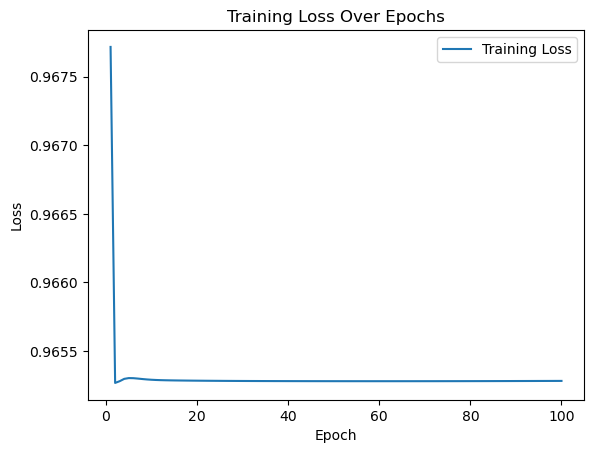

In [ ]:
# Plot the training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.savefig("visualisation/train_loss.png", dpi = 500)
plt.show()

## 4. Test the model

In [ ]:
# Initialize variables for evaluation
total_loss = 0.0
total_samples = 0

# Put model in evaluation mode
model.eval()

# Disable gradient calculation to save memory and computation
with torch.no_grad():
    for policy_features, flow_targets in test_data_sets:
        # Assuming test_data_sets is a DataLoader or similar iterable
        policy_features = policy_features.float()  # Convert to float tensor if necessary
        flow_targets = flow_targets.float()  # Convert to float tensor if necessary
        traffic_features = flow_targets.unsqueeze(1)  # Adjust as necessary

        # Forward pass
        predicted_flow = model(policy_features, traffic_features, adjacency_matrix)
        
        # Compute loss
        loss = criterion(predicted_flow, traffic_features)
        
        # Accumulate total loss and total samples
        total_loss += loss.item() * policy_features.size(0)
        total_samples += policy_features.size(0)

# Calculate average loss over all samples
average_loss = total_loss / total_samples
# squared differences between your model’s predictions and the actual target values.
# unit: squared flow values.

print(f"Average Test Loss: {average_loss}")

Average Test Loss: 2890.6429734002977
